In [1]:

import os
import sys
import matplotlib.pyplot as plt

# Use os.getcwd() to get the current working directory
main_directory = os.getcwd()
parent_directory = os.path.dirname(main_directory)
parent_directory = os.path.dirname(parent_directory)


# Define the subdirectories you want to add to sys.path
subdirs = ['MaSeq', 'marcos_client']

# Add the subdirectories to sys.path
for subdir in subdirs:
    full_path = os.path.join(parent_directory, subdir)
    sys.path.append(full_path)
#******************************************************************************

In [2]:


from seq.utils import sort_data_implicit, plot_nd, ifft_2d, combine_coils
import pypulseq as pp
import numpy as np
import seq.mriBlankSeq as blankSeq   
import configs.units as units
import scipy.signal as sig
import experiment_multifreq as ex
import configs.hw_config_pseq as hw
from flocra_pulseq.interpreter_pseq import PseqInterpreter
from pypulseq.convert import convert
class SPRITER2dSEQ(blankSeq.MRIBLANKSEQ):
    def __init__(self, nScans=None, larmorFreq=None, rfExFA=None, repetitionTime=None,
                                           rfExTime=None, echoTime=None, nPoints=None, riseTime=None,
                 SpoilingTimeAfterRising=None, fov=None, bandwidth=None,
                 SamplingPoints=None, shimming=None, txChannel=None, rxChannel=None,
                 axesOrientation=None):
        super(SPRITER2dSEQ, self).__init__()
        # Input the parameters

        self.nScans = np.array(nScans)
        self.larmorFreq = np.array(larmorFreq)
        self.rfExFA = np.array(rfExFA)
        self.repetitionTime = np.array(repetitionTime)
        self.rfExTime = np.array(rfExTime)
        self.echoTime = np.array(echoTime)
        self.nPoints = np.array(nPoints)
        self.riseTime = np.array(riseTime)
        self.SpoilingTimeAfterRising = np.array(SpoilingTimeAfterRising)
        self.fov = np.array(fov)
        self.bandwidth = np.array(bandwidth)
        self.SamplingPoints = np.array(SamplingPoints)
        self.shimming = np.array(shimming)
        self.txChannel = np.array(txChannel)
        self.rxChannel = np.array(rxChannel)
        self.axesOrientation = np.array(axesOrientation)


        self.addParameter(key='seqName', string='SpriteInfo', val='TSE')
        self.addParameter(key='nScans', string='Number of scans', val=nScans, field='SEQ')
        self.addParameter(key='larmorFreq', string='Larmor frequency (MHz)', val=larmorFreq, units=units.MHz, field='RF')
        self.addParameter(key='rfExFA', string='Excitation flip angle (deg)', val=rfExFA, field='RF')
        self.addParameter(key='repetitionTime', string='Repetition time (ms)', val=repetitionTime, units=units.ms, field='SEQ')
        self.addParameter(key='rfExTime', string='RF excitation time (us)', val=rfExTime, units=units.us, field='RF')
        self.addParameter(key='echoTime', string='Echo time (ms)', val=echoTime, units=units.ms, field='SEQ')
        self.addParameter(key='nPoints', string='Number of acquired points', val=nPoints, field='IM')
        self.addParameter(key='riseTime', string='Grad. Rise time (ms)', val=riseTime, units=units.ms, field='OTH')
        self.addParameter(key='SpoilingTimeAfterRising', string='Grad. soiling time after grad. rising (ms)', val=SpoilingTimeAfterRising, units=units.ms, field='OTH')
        self.addParameter(key='fov', string='FOV [x,y](mm)', val=fov, units=units.mm, field='IM')
        self.addParameter(key='bandwidth', string='Acquisition Bandwidth (kHz)', val=bandwidth, units=units.kHz, field='IM',
                                tip="The bandwidth of the acquisition (kHz). This value affects resolution and SNR.")
        self.addParameter(key='SamplingPoints', string='Sampling Points Number[x,y]', val=SamplingPoints, field='IM')
        self.addParameter(key='shimming', string='shimming', val=shimming, units=units.sh, field='OTH')
        self.addParameter(key='txChannel', string='Tx channel', val=txChannel, field='RF')
        self.addParameter(key='rxChannel', string='Rx channel', val=rxChannel, field='RF')
        self.addParameter(key='axesOrientation', string='Axes[rd,ph,sl]', val=axesOrientation, field='IM',
                          tip="0=x, 1=y, 2=z")
    def sequenceInfo(self):
        pass
        
    def sequenceTime(self):
        return (self.mapVals['repetitionTime'] *1e-3 * self.mapVals['SamplingPoints'][0] * self.mapVals['SamplingPoints'][1] * self.mapVals['nScans'] / 60)  # minutes

    def sequenceAtributes(self):
        super().sequenceAtributes()
        
    
    def sequenceRun(self, plotSeq=0, demo=False, standalone=False):
        init_gpa = False
        self.demo = demo
        self.plotSeq = plotSeq
        self.standalone = standalone

        max_grad_Hz = convert(from_value=hw.max_grad, from_unit='mT/m', gamma=hw.gammaB, to_unit='Hz/m')
        
        rfExTime_us = int(np.round(self.rfExTime * 1e6))
        assert rfExTime_us in hw.max_cpmg_rf_arr, f"RF excitation time '{rfExTime_us}' s is not found in the hw_config_pseq file; please search it in search_p90_pseq."
        
        max_rf_Hz = hw.max_cpmg_rf_arr[rfExTime_us] * 1e-6 * hw.gammaB
        self.flo_interpreter = PseqInterpreter(
            tx_warmup=10,  # Transmit chain warm-up time (us)
            rf_center=hw.larmorFreq * 1e6 ,  # Larmor frequency (Hz)
            rf_amp_max=max_rf_Hz,  # Maximum RF amplitude (Hz)
            grad_max=max_grad_Hz,  # Maximum gradient amplitude (Hz/m)
            grad_t=10,  # Gradient raster time (us)
            orientation=self.axesOrientation, # gradient orientation
            grad_eff=hw.gradFactor, # gradient coefficient of efficiency
            tx_ch = self.txChannel, # Transmit channel
            rx_ch = self.rxChannel, # Receive channel
            add_rx_points = 0, # Additional points for the receiver
            tx_t= 1229/122.88, # us
            grad_zero_end=False,
            use_multi_freq=False, # Use multi-frequency mode
            use_grad_preemphasis=False,
            grad_preemphasis_coeff={
                        'xx':( (np.array([0.383494796, 0.159428847, 0.06601789, 0.03040273]), 
                            np.array([384.543433, 4353.01123, 46948.52793, 485123.9174] ))),
                        'yy':( (np.array([0.383494796, 0.159428847, 0.06601789, 0.03040273]),
                            np.array([384.543433, 4353.01123, 46948.52793, 485123.9174] ))),
                        'zz':( (np.array([0.383494796, 0.159428847, 0.06601789, 0.03040273]),
                            np.array([384.543433, 4353.01123, 46948.52793, 485123.9174] ))),
                 },
            use_fir_decimation = (self.bandwidth < 30.007326007326007e3), # 30kHz
        )
        assert (self.txChannel == 0 or self.txChannel == 1)
        assert (self.rxChannel == 0 or self.rxChannel == 1)
        self.rxChName = 'rx0' if (self.rxChannel == 0) else 'rx1'
        self.mapVals['rxChName'] = 'rx0'

        self.system = pp.Opts(
            rf_dead_time=10 * 1e-6,  # Dead time between RF pulses (s)
            rf_ringdown_time= 10 * 1e-6,
            max_grad=60,  # Maximum gradient strength (mT/m)
            grad_unit='mT/m',  # Units of gradient strength
            max_slew=hw.max_slew_rate,  # Maximum gradient slew rate (mT/m/ms)
            slew_unit='mT/m/ms',  # Units of gradient slew rate
            grad_raster_time=hw.grad_raster_time,  # Gradient raster time (s)
            rise_time=self.riseTime,  # Gradient rise time (s)
            rf_raster_time=10e-6,
            block_duration_raster=1e-6,
            adc_raster_time=1/(122.88e6)
        )

        bw = self.bandwidth * 1e-6 # MHz
        bw_ov = bw
        sampling_period = 1 / bw_ov  # us, Dwell time

        if not self.demo:
            expt = ex.Experiment(
                lo_freq=hw.larmorFreq,  # Larmor frequency in MHz
                rx_t=sampling_period,  # Sampling time in us
                init_gpa=False,  # Whether to initialize GPA board (False for True)
                gpa_fhdo_offset_time=(1 / 0.2 / 3.1),  # GPA offset time calculation
                auto_leds=True  # Automatic control of LEDs (False or True)
            )
            sampling_period = expt.get_rx_ts()[0]  # us
            bw = 1 / sampling_period # / hw.oversamplingFactor  # MHz
            print("Acquisition bandwidth fixed to: %0.3f kHz" % (bw * 1e3))
            expt.__del__()
        self.mapVals['bw_MHz'] = bw
        self.mapVals['sampling_period_us'] = sampling_period
        self.mapVals['acqTime'] = self.nPoints / bw * 1e-3 # ms

        readout_duration = sampling_period * 1e-6 * self.nPoints

        readout_duration_rounded = np.ceil(sampling_period * self.nPoints / 10) * 10 * 1e-6
        if not self.demo:
            print(f'dwell time: {sampling_period} us, readout time: {readout_duration} s')
        
    
        delay_TE = np.round((self.echoTime - 0.5 * self.rfExTime - self.system.rf_ringdown_time) / self.system.grad_raster_time) * self.system.grad_raster_time
        delay_Spoiling_before_rising = np.round((self.repetitionTime - 0.5 * self.rfExTime - self.system.rf_dead_time 
             -self.riseTime - self.SpoilingTimeAfterRising - readout_duration_rounded) / self.system.grad_raster_time) * self.system.grad_raster_time
        assert delay_TE > 0, f"Error: delay_TE is non-positive: {delay_TE}"
        assert delay_Spoiling_before_rising > 0, f"Error: SpoilingTimeAfterRising is non-positive: {delay_Spoiling_before_rising}"

        rf_ex = pp.make_block_pulse(
            flip_angle=self.rfExFA * np.pi / 180,
            duration=self.rfExTime,
            system=self.system,
            phase_offset=0 * np.pi / 180,
            delay=0,
        )
        adc = pp.make_adc(num_samples=self.nPoints, duration=readout_duration) 
        
        delta_kx = 1 / self.fov[0]
        delta_ky = 1 / self.fov[1]
        phase_areas_x = (np.arange(self.SamplingPoints[0]) - self.SamplingPoints[0] // 2) * delta_kx
        phase_amp_x = phase_areas_x / self.echoTime
        phase_areas_y = (np.arange(self.SamplingPoints[1]) - self.SamplingPoints[1] // 2) * delta_ky
        phase_amp_y = phase_areas_y / self.echoTime
        
        acq_points = 0
        seq = pp.Sequence(system=self.system)

        def make_flat_grad(duration, amplitude_list):
            dur = duration
            grad_flat_time = np.array([0, dur])
            grad_x = pp.make_extended_trapezoid(channel="x", times=grad_flat_time, amplitudes=np.array([amplitude_list[0], amplitude_list[0]]), system=self.system)
            grad_y = pp.make_extended_trapezoid(channel="y", times=grad_flat_time, amplitudes=np.array([amplitude_list[1], amplitude_list[1]]), system=self.system)
            grad_z = pp.make_extended_trapezoid(channel="z", times=grad_flat_time, amplitudes=np.array([amplitude_list[2], amplitude_list[2]]), system=self.system)
            return grad_x, grad_y, grad_z

        if True:
        # for scan in range(self.nScans):
            last_phase_amp_x = 0
            last_phase_amp_y = 0
        
            for ind_y in range(self.SamplingPoints[1]):
                current_phase_amp_y = phase_amp_y[ind_y]
                rise_z = pp.make_extended_trapezoid(
                        channel="z", 
                        times=np.array([0, self.riseTime]),
                        amplitudes=np.array([0, 0]),
                        system=self.system)
                for ind in range(self.SamplingPoints[0]):
                    
                    current_phase_amp_x = phase_amp_x[ind]
                    rise_x = pp.make_extended_trapezoid(
                        channel="x", 
                        times=np.array([0, self.riseTime]),
                        amplitudes=np.array([last_phase_amp_x, current_phase_amp_x]),
                        system=self.system)
                    rise_y = pp.make_extended_trapezoid(
                        channel="y", 
                        times=np.array([0, self.riseTime]),
                        amplitudes=np.array([last_phase_amp_y, current_phase_amp_y]),
                        system=self.system)
                    grad_Hz = np.array([current_phase_amp_x, current_phase_amp_y, 0]) 
                    seq.add_block(rise_x, rise_y, rise_z)
                    seq.add_block(pp.make_delay(self.SpoilingTimeAfterRising), *make_flat_grad(pp.calc_duration(self.SpoilingTimeAfterRising), grad_Hz))
                    seq.add_block(rf_ex, *make_flat_grad(pp.calc_duration(rf_ex), grad_Hz))
                    seq.add_block(pp.make_delay(delay_TE), *make_flat_grad(pp.calc_duration(delay_TE), grad_Hz))
                    seq.add_block(adc, pp.make_delay(readout_duration_rounded), *make_flat_grad(pp.calc_duration(readout_duration_rounded), grad_Hz))
                    acq_points += self.nPoints
                    delay_spoiling = pp.make_delay(delay_Spoiling_before_rising)
                    seq.add_block(delay_spoiling, *make_flat_grad(pp.calc_duration(delay_spoiling), grad_Hz))
                    last_phase_amp_x = current_phase_amp_x
                    last_phase_amp_y = current_phase_amp_y
            fall_x = pp.make_extended_trapezoid(
                channel="x", 
                times=np.array([0, self.riseTime]),
                amplitudes=np.array([last_phase_amp_x, 0]),
                system=self.system
            )
            fall_y = pp.make_extended_trapezoid(
                channel="y", 
                times=np.array([0, self.riseTime]),
                amplitudes=np.array([last_phase_amp_y, 0]),
                system=self.system
            )
            seq.add_block(fall_x, fall_y)
            
        if plotSeq:
            # Check whether the timing of the sequence is correct
            ok, error_report = seq.check_timing()
            if ok:
                print("Timing check passed successfully")
            else:
                print("Timing check failed. Error listing follows:")
                [print(e) for e in error_report]   
            print(seq.test_report())
            seq.plot(show_blocks =False)
            k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc = seq.calculate_kspace()

            plt.figure(10)
            plt.plot(k_traj[0],k_traj[1],linewidth=1)
            plt.plot(k_traj_adc[0],k_traj_adc[1],'.', markersize=1.4)
            plt.axis("equal")
            plt.title("k-space trajectory (kx/ky)")

            plt.figure(11)
            plt.plot(t_adc, k_traj_adc.T, linewidth=1)
            plt.xlabel("Time of acqusition (s)")
            plt.ylabel("Phase")
            
            plt.figure(12)
            t = np.linspace(0, 1, k_traj_adc.shape[1])  # 归一化时间
            plt.scatter(k_traj_adc[0], k_traj_adc[1], c=t, cmap='viridis', s=2)  # 用颜色表示时间
            plt.axis("equal")
            plt.colorbar(label='Normalized Time')  # 添加颜色条
            plt.title("k-space trajectory (kx/ky) with Gradient")
            plt.show()

        seq.set_definition(key="Name", value="SPRITE1D")
        seq.write("SPRITE1D.seq")
        self.waveforms, param_dict = self.flo_interpreter.interpret("SPRITE1D.seq")
         
        larmorFreq = self.mapVals['larmorFreq']
        if not self.demo:
            self.expt = ex.Experiment(
                lo_freq=(self.larmorFreq + 0) * 1e-6,  # Larmor frequency in MHz
                rx_t= sampling_period,
                init_gpa=False,  # Whether to initialize GPA board (False for now)
                gpa_fhdo_offset_time=(1 / 0.2 / 3.1),  # GPA offset time calculation
                auto_leds=True  # Automatic control of LEDs
            )
        print(f"Center frequecy set: {(self.larmorFreq + 0) * 1e-6} MHz")
        # Convert the PyPulseq waveform to the Red Pitaya compatible format
        self.pypulseq2mriblankseqV2(waveforms=self.waveforms, shimming=self.shimming)
        
        # Load the waveforms into Red Pitaya
        if not self.floDict2Exp_ms():
            print("ERROR: Sequence waveforms out of hardware bounds")
            return False
        else:
            encoding_ok = True
            # print("Sequence waveforms loaded successfully")

        if self.plotSeq and self.standalone:
            # Plot the sequence if requested and return immediately
            self.expt.plot_sequence()
            self.sequencePlot(standalone=self.standalone)
            
        data_over = []
         
        # If not plotting the sequence, start scanning
        if not self.plotSeq:
            self.mapVals['data_full'] = []
            # for scan in range(self.nScans):
            for scan in range(self.nScans):
                print(f"Scan {scan + 1} running...")
                acquired_points = 0
                expected_points = self.nPoints * self.SamplingPoints[0] * self.SamplingPoints[1]  # Expected number of points

                # Continue acquiring points until we reach the expected number
                while acquired_points != expected_points:
                    if not self.demo:
                        rxd, msgs = self.expt.run()  # Run the experiment and collect data
                    else:
                        # In demo mode, generate random data as a placeholder
                        rxd = {self.rxChName: np.random.randn(expected_points + self.flo_interpreter.get_add_rx_points()) + 1j * np.random.randn(expected_points + + self.flo_interpreter.get_add_rx_points())}
                    # Update acquired points
                    rx_raw_data = rxd[self.rxChName]
                    add_rx_points = self.flo_interpreter.get_add_rx_points()
                    before_delete = np.reshape(rx_raw_data, newshape=(1, -1))
                    rxdataremove = before_delete[:, add_rx_points:]
                    rxdata = np.reshape(rxdataremove, newshape=(-1))
                    acquired_points = np.size(rxdata)


                    # Check if acquired points coincide with expected points
                    if acquired_points != expected_points:
                        print("WARNING: data apoints lost!")
                        print("Repeating batch...")

                # Concatenate acquired data into the oversampled data array
                data_over = np.concatenate((data_over, rxdata), axis=0)
                print(f"Acquired points = {acquired_points}, Expected points = {expected_points}")
                print(f"Scan {scan + 1} ready!")
                # plt.plot(data_over)
                # plt.show()
            # Decimate the oversampled data and store it
            self.mapVals['data_over'] = data_over
            self.mapVals['data_full'] = np.concatenate((self.mapVals['data_full'], self.mapVals['data_over']), axis=0)
        

        if not self.demo:
            self.expt.__del__()

        self.mapVals['n_readouts'] = self.nPoints
        return True

        

    def sequenceAnalysis(self, mode=None):
        self.mode = mode
        self.etl = 1 # for ssfp
        #self.axesOrientation = [0,1,2] # for ssfp
        self.unlock_orientation = 0 # for ssfp
        resolution = self.fov / self.SamplingPoints
        self.mapVals['resolution'] = resolution

        nRD, nPH, nSL = self.SamplingPoints[0], self.SamplingPoints[1], 1
        nRD = nRD + 2 * hw.addRdPoints
        n_batches = 1

        # Get data
        data_full_pre = self.mapVals['data_full']
        
        # fir decimator
        if self.flo_interpreter._fir_decimation_rate > 1:
            data_waiting_for_fir = np.reshape(data_full_pre, newshape=(-1, self.flo_interpreter._fir_decimation_rate * nRD))
            data_full = self.flo_interpreter.fir_decimator(input_matrix=data_waiting_for_fir, decimation_rate=3)
        else:
            data_full = data_full_pre
        

        # Reorganize data_full
        data_prov = np.zeros([self.nScans, nRD * nPH * nSL ], dtype=complex)
        if n_batches > 1:
            n_rds = self.mapVals['n_readouts']
            data_full_a = data_full[0:sum(n_rds[0:-1]) * self.nScans]
            data_full_b = data_full[sum(n_rds[0:-1]) * self.nScans:]
            data_full_a = np.reshape(data_full_a, newshape=(n_batches - 1, self.nScans, -1, nRD))
            data_full_b = np.reshape(data_full_b, newshape=(1, self.nScans, -1, nRD))
            for scan in range(self.nScans):
                data_scan_a = np.reshape(data_full_a[:, scan, :, :], -1)
                data_scan_b = np.reshape(data_full_b[:, scan, :, :], -1)
                data_prov[scan, :] = np.concatenate((data_scan_a, data_scan_b), axis=0)
        else:
            data_full = np.reshape(data_full, (1, self.nScans, -1, nRD))
            for scan in range(self.nScans):
                data_prov[scan, :] = np.reshape(data_full[:, scan, :, :], -1)
        
        # [TODO]: Add Rx phase here
        expiangle = self.flo_interpreter.get_rx_phase_dict()['rx0']
        raw_data = np.reshape(data_prov, newshape=(1, self.nScans, -1, nRD))
        for scan in range(self.nScans):
            for line in range(raw_data.shape[2]):
                raw_data[0, scan, line, :] = raw_data[0, scan, line, :] * expiangle[line]
        data_full = np.reshape(raw_data, -1)
        
        # Average data
        data_full = np.reshape(data_full, newshape=(self.nScans, -1))
        data = np.average(data_full, axis=0)
        self.mapVals['data'] = data
        


        # Original methods to reconstruct:
        # slice_idx = self.mapVals['sliceIdx']
        # data_arrange_slice = np.zeros(shape=(nSL, nPH, nRD), dtype=complex)
        # data_shape = np.reshape(data, newshape=(nPH, nSL, nRD))
        # for s_i in range(nSL):
        #     data_arrange_slice[slice_idx[s_i], :, :] = data_shape[:, s_i, :]

        # data_ind = np.reshape(data_arrange_slice, newshape=(1, nSL, nPH, nRD))
        # data_ind = data_ind[:, :, :, hw.addRdPoints: nRD - hw.addRdPoints]
        # self.mapVals['kSpace'] = data_ind
        

        # sort method to reconstruct:
        n_ex = int(np.floor(self.SamplingPoints[1]))
        data_shape = np.reshape(data, newshape=(n_ex, nSL, 1, nRD))
        
        kdata_input = np.reshape(data_shape, newshape=(1, -1, nRD))
        # data_ind = sort_data_implicit(kdata=kdata_input, seq=self.lastseq, shape=(nSL, nPH, nRD))
        data_ind = kdata_input
        data_ind = np.reshape(data_ind, newshape=(1, nSL, nPH, nRD))
        self.mapVals['kSpace'] = data_ind

        # Get images
        
        image_ind = np.zeros_like(data_ind)
        for s in range(nSL):
            image_ind[0,s,:,:] = np.fft.ifftshift(np.fft.ifftn(np.fft.ifftshift(data_ind[0,s,:,:])))
        self.mapVals['iSpace'] = image_ind
        
        # Prepare data to plot (plot central slice)
        axes_dict = {'x': 0, 'y': 1, 'z': 2}
        axes_keys = list(axes_dict.keys())
        axes_vals = list(axes_dict.values())
        axes_str = ['', '', '']
        n = 0
        for val in self.axesOrientation:
            index = axes_vals.index(val)
            axes_str[n] = axes_keys[index]
            n += 1

        # Normalize image
        k_space = np.zeros((self.etl * nSL, nPH, nRD - 2 * hw.addRdPoints))
        image = np.zeros((self.etl * nSL, nPH, nRD - 2 * hw.addRdPoints))

        
        n = 0
        for slice in range(nSL):
            for echo in range(self.etl):
                k_space[n, :, :] = np.abs(data_ind[echo, slice, :, :])
                image[n, :, :] = np.abs(image_ind[echo, slice, :, :])
                n += 1
        image = image / np.max(image) * 100
        # plt.plot(np.real(k_space[0,0,:]))
        # plt.show()
        imageOrientation_dicom = [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
        if not self.unlock_orientation:  # Image orientation
            
            if self.axesOrientation[2] == 2:  # Sagittal
                title = "Sagittal"
                if self.axesOrientation[0] == 0 and self.axesOrientation[1] == 1:  # OK
                    image = np.flip(image, axis=2)
                    image = np.flip(image, axis=1)
                    k_space = np.flip(k_space, axis=2)
                    k_space = np.flip(k_space, axis=1)
                    x_label = "(-Y) A | PHASE | P (+Y)"
                    y_label = "(-X) I | READOUT | S (+X)"
                    imageOrientation_dicom = [0.0, 1.0, 0.0, 0.0, 0.0, -1.0]
                else:
                    image = np.transpose(image, (0, 2, 1))
                    image = np.flip(image, axis=2)
                    image = np.flip(image, axis=1)
                    k_space = np.transpose(k_space, (0, 2, 1))
                    k_space = np.flip(k_space, axis=2)
                    k_space = np.flip(k_space, axis=1)
                    x_label = "(-Y) A | READOUT | P (+Y)"
                    y_label = "(-X) I | PHASE | S (+X)"
                    imageOrientation_dicom = [0.0, 1.0, 0.0, 0.0, 0.0, -1.0]
            elif self.axesOrientation[2] == 1:  # Coronal
                title = "Coronal"
                if self.axesOrientation[0] == 0 and self.axesOrientation[1] == 2:  # OK
                    image = np.flip(image, axis=2)
                    image = np.flip(image, axis=1)
                    image = np.flip(image, axis=0)
                    k_space = np.flip(k_space, axis=2)
                    k_space = np.flip(k_space, axis=1)
                    k_space = np.flip(k_space, axis=0)
                    x_label = "(+Z) R | PHASE | L (-Z)"
                    y_label = "(-X) I | READOUT | S (+X)"
                    imageOrientation_dicom = [1.0, 0.0, 0.0, 0.0, 0.0, -1.0]
                else:
                    image = np.transpose(image, (0, 2, 1))
                    image = np.flip(image, axis=2)
                    image = np.flip(image, axis=1)
                    image = np.flip(image, axis=0)
                    k_space = np.transpose(k_space, (0, 2, 1))
                    k_space = np.flip(k_space, axis=2)
                    k_space = np.flip(k_space, axis=1)
                    k_space = np.flip(k_space, axis=0)
                    x_label = "(+Z) R | READOUT | L (-Z)"
                    y_label = "(-X) I | PHASE | S (+X)"
                    imageOrientation_dicom = [1.0, 0.0, 0.0, 0.0, 0.0, -1.0]
            elif self.axesOrientation[2] == 0:  # Transversal
                title = "Transversal"
                if self.axesOrientation[0] == 1 and self.axesOrientation[1] == 2:
                    image = np.flip(image, axis=2)
                    image = np.flip(image, axis=1)
                    k_space = np.flip(k_space, axis=2)
                    k_space = np.flip(k_space, axis=1)
                    x_label = "(+Z) R | PHASE | L (-Z)"
                    y_label = "(+Y) P | READOUT | A (-Y)"
                    imageOrientation_dicom = [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
                else:  # OK
                    image = np.transpose(image, (0, 2, 1))
                    image = np.flip(image, axis=2)
                    image = np.flip(image, axis=1)
                    k_space = np.transpose(k_space, (0, 2, 1))
                    k_space = np.flip(k_space, axis=2)
                    k_space = np.flip(k_space, axis=1)
                    x_label = "(+Z) R | READOUT | L (-Z)"
                    y_label = "(+Y) P | PHASE | A (-Y)"
                    imageOrientation_dicom = [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
        else:
            x_label = "%s axis" % axes_str[1]
            y_label = "%s axis" % axes_str[0]
            title = "Image"

        result1 = {'widget': 'image',
                   'data': image,
                   'xLabel': x_label,
                   'yLabel': y_label,
                   'title': title,
                   'row': 0,
                   'col': 0}

        result2 = {'widget': 'image',
                   'data': np.log10(k_space+0.01), # plus 0.01 in case of log(0) = -inf
                   'xLabel': x_label,
                   'yLabel': y_label,
                   'title': "k_space",
                   'row': 0,
                   'col': 1}
 

        # Dicom tags
        image_DICOM = np.transpose(image, (0, 2, 1))
        slices, rows, columns = image_DICOM.shape
        self.meta_data["Columns"] = columns
        self.meta_data["Rows"] = rows
        self.meta_data["NumberOfSlices"] = slices
        self.meta_data["NumberOfFrames"] = slices
        img_full_abs = np.abs(image_DICOM) * (2 ** 15 - 1) / np.amax(np.abs(image_DICOM))
        img_full_int = np.int16(np.abs(img_full_abs))
        img_full_int = np.reshape(img_full_int, newshape=(slices, rows, columns))
        arr = img_full_int
        self.meta_data["PixelData"] = arr.tobytes()
        self.meta_data["WindowWidth"] = 26373
        self.meta_data["WindowCenter"] = 13194
        self.meta_data["ImageOrientationPatient"] = imageOrientation_dicom
        resolution = self.mapVals['resolution'] * 1e3
        self.meta_data["PixelSpacing"] = [resolution[0], resolution[1]]
        # self.meta_data["SliceThickness"] = resolution[2]
        # Sequence parameters
        self.meta_data["RepetitionTime"] = self.mapVals['repetitionTime']
        self.meta_data["EchoTime"] = self.mapVals['echoTime']
        self.meta_data["FlipAngle"] = self.mapVals['rfExFA']
        self.meta_data["NumberOfAverages"] = self.mapVals['nScans']
        # self.meta_data["EchoTrainLength"] = self.mapVals['etl']
        
        self.meta_data["ScanningSequence"] = 'SPRITE'

        # create self.out to run in iterative mode
        self.output = [result1, result2]

        # save data once self.output is created
        self.saveRawData()

        # Plot result in standalone execution
        if self.mode == 'Standalone':
            self.plotResults()

        return self.output
 

/home/lks/.local/lib/python3.12/site-packages/sigpy/config.py:27: UserWarning: Importing cupy.cuda.cudnn failed. For more details, see the error stack below:
libcudnn.so.8: cannot open shared object file: No such file or directory
  warnings.warn(
/home/lks/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:

seq = SPRITER2dSEQ(nScans=1, larmorFreq=10.33362, rfExFA=90, repetitionTime=10,
                 rfExTime=30, echoTime=0.3, nPoints=1, riseTime=0.5,
                 SpoilingTimeAfterRising=8.0, fov=[150, 150], bandwidth=106.66666666666667,
                 SamplingPoints=[128, 128], shimming=[0.001, -0.006, 0.001], txChannel=0, rxChannel=0,
                 axesOrientation=[1, 2, 0])

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 2.0 min 43.84 seconds
Acquisition bandwidth fixed to: 106.667 kHz
dwell time: 9.375 us, readout time: 9.375e-06 s
read 5 definitions, 98305 blocks, 138 shapes, 1 adc events, 1 rf events, 898 gradient shapes
Center frequecy set: 10.33362 MHz
Scan 1 running...


/home/lks/MaSeq_pack/marcos_client/experiment.py:229: UserWarning: Unknown marga experiment dictionary key: lo0_freq_offset
  warnings.warn("Unknown marga experiment dictionary key: " + key)
/home/lks/MaSeq_pack/marcos_client/experiment.py:229: UserWarning: Unknown marga experiment dictionary key: lo1_freq_offset
  warnings.warn("Unknown marga experiment dictionary key: " + key)
/home/lks/MaSeq_pack/marcos_client/experiment.py:229: UserWarning: Unknown marga experiment dictionary key: lo0_rst
  warnings.warn("Unknown marga experiment dictionary key: " + key)
/home/lks/MaSeq_pack/marcos_client/experiment.py:229: UserWarning: Unknown marga experiment dictionary key: lo1_rst
  warnings.warn("Unknown marga experiment dictionary key: " + key)
/home/lks/MaSeq_pack/marcos_client/marcompile.py:245: MarGradWarning: Gradient updates are too frequent for selected SPI divider. Missed samples are likely!
  warnings.warn("Gradient updates are too frequent for selected SPI divider. Missed samples are

Acquired points = 16384, Expected points = 16384
Scan 1 ready!


/home/lks/MaSeq_pack/marcos_client/server_comms.py:86: MarServerWarning: ocra1 data was lost (overwritten before being sent)
  warnings.warn(k, MarServerWarning)


KeyError: 'data'

Moved: raw_data_20250624_154849 to experiments/acquisitions/2025.06.24


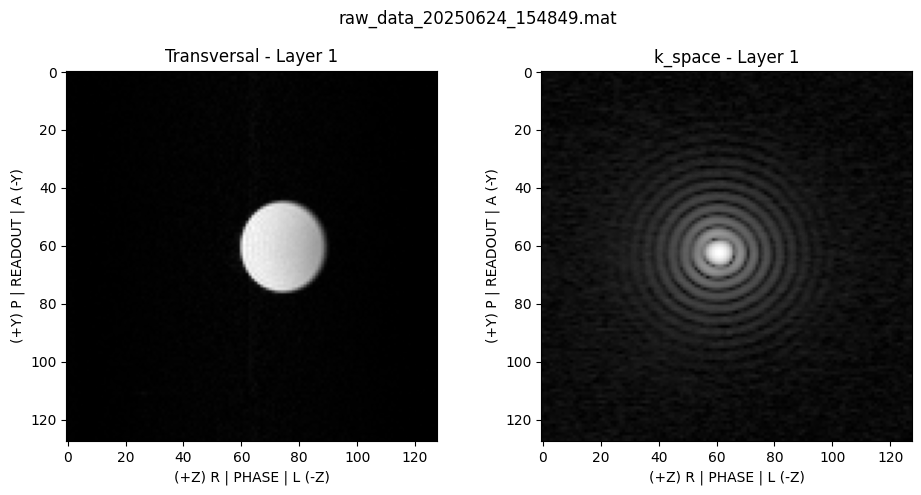

[{'widget': 'image',
  'data': array([[[0.00632504, 0.21037085, 0.70992741, ..., 0.13142629,
           0.31680199, 0.27780942],
          [0.38560562, 0.23566123, 0.3126792 , ..., 0.15278092,
           0.44710859, 0.31908589],
          [0.18613912, 0.48754791, 0.51280363, ..., 0.20800866,
           0.37151731, 0.46809072],
          ...,
          [0.2959632 , 0.3457421 , 0.62779344, ..., 0.14807945,
           0.33994313, 0.08500849],
          [0.35432547, 0.54145084, 0.573016  , ..., 0.20942037,
           0.14112654, 0.13779657],
          [0.15875431, 0.66811777, 0.50120315, ..., 0.09779457,
           0.08578568, 0.43334942]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.88905572, -1.89029818, -1.90592619, ..., -1.96969428,
           -1.95190974, -1.94619011],
          [-1.96899519, -1.9298914 , -1.94700072, ..., -1.8930852 ,
           -1.88429

In [6]:
seq.sequenceAnalysis(mode='Standalone')

seq total time: 2.0 min 43.84 seconds
Acquisition bandwidth fixed to: 106.667 kHz
dwell time: 9.375 us, readout time: 9.375e-06 s
read 5 definitions, 98305 blocks, 138 shapes, 1 adc events, 1 rf events, 898 gradient shapes
Center frequecy set: 10.33362 MHz
Scan 1 running...
Acquired points = 16384, Expected points = 16384
Scan 1 ready!
------------ max abs value: 0.7031456749859409
Moved: raw_data_20250624_155709 to experiments/acquisitions/2025.06.24


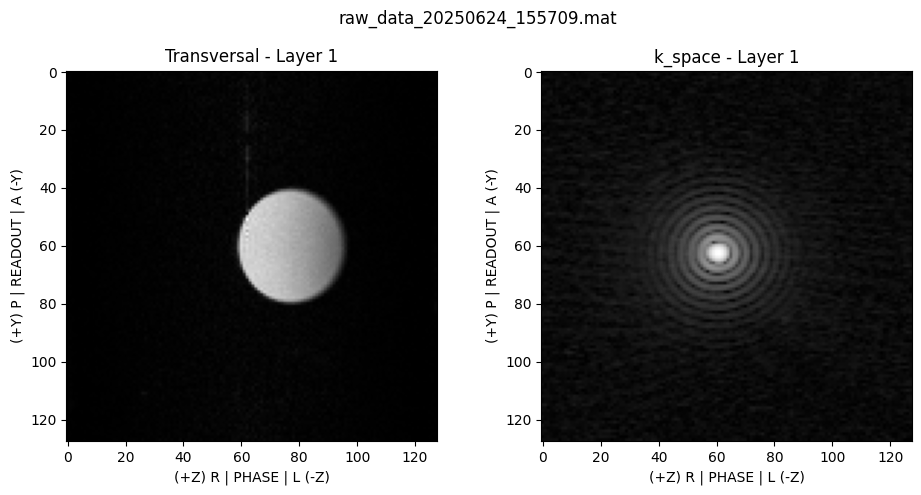

[{'widget': 'image',
  'data': array([[[0.54304368, 0.57269894, 0.12437481, ..., 0.48527506,
           0.68456368, 0.17285889],
          [0.14207709, 0.52652615, 0.22388645, ..., 0.65471933,
           0.69223246, 0.50420508],
          [0.06489135, 0.48392922, 0.17547384, ..., 0.2203044 ,
           0.48953137, 0.34210069],
          ...,
          [0.11522942, 0.45725744, 0.32603846, ..., 0.16365871,
           0.55097351, 0.5001816 ],
          [0.5982088 , 0.41269634, 0.28091448, ..., 0.52642288,
           0.38572679, 0.33429516],
          [0.47463261, 0.17397031, 0.31714615, ..., 0.34590012,
           0.46279344, 0.14651611]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.92096188, -1.89265344, -1.93106642, ..., -1.92181685,
           -1.94806743, -1.93748344],
          [-1.97334109, -1.96989517, -1.92377414, ..., -1.96886544,
           -1.99662

In [7]:

seq = SPRITER2dSEQ(nScans=1, larmorFreq=10.33362, rfExFA=90, repetitionTime=10,
                 rfExTime=30, echoTime=0.3, nPoints=1, riseTime=0.5,
                 SpoilingTimeAfterRising=8.0, fov=[120, 120], bandwidth=106.66666666666667,
                 SamplingPoints=[128, 128], shimming=[0.001, -0.006, 0.001], txChannel=0, rxChannel=0,
                 axesOrientation=[1, 2, 0])

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone')


seq total time: 2.0 min 43.84 seconds
Acquisition bandwidth fixed to: 106.667 kHz
dwell time: 9.375 us, readout time: 9.375e-06 s
read 5 definitions, 98305 blocks, 138 shapes, 1 adc events, 1 rf events, 898 gradient shapes
Center frequecy set: 10.33362 MHz
Scan 1 running...
Acquired points = 16384, Expected points = 16384
Scan 1 ready!
------------ max abs value: 0.6560820944652257
Moved: raw_data_20250624_160139 to experiments/acquisitions/2025.06.24


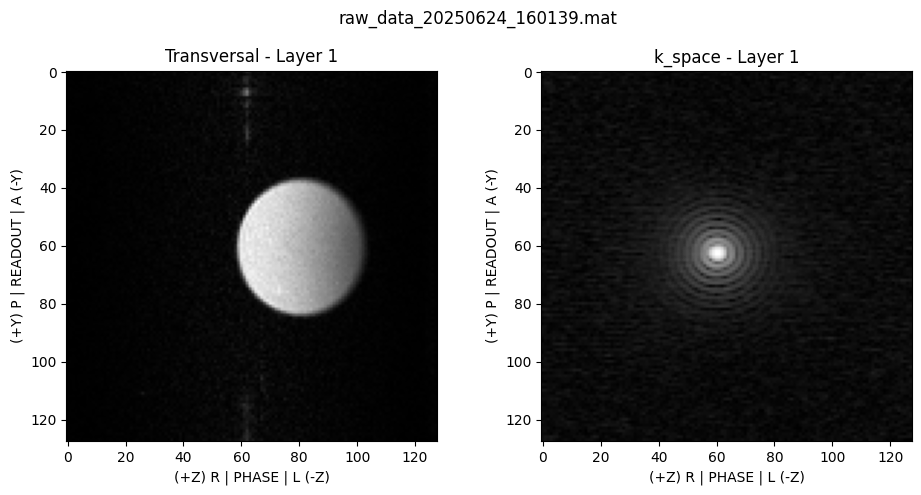

[{'widget': 'image',
  'data': array([[[0.86031921, 0.73187771, 0.21092817, ..., 0.55545232,
           0.46956703, 0.49373179],
          [0.24526339, 0.67331594, 0.26329625, ..., 0.60379309,
           1.1774873 , 0.96784454],
          [0.54580553, 0.11237395, 0.42291921, ..., 0.5192891 ,
           0.66351096, 1.23520604],
          ...,
          [0.94268165, 0.36404462, 0.24426605, ..., 0.88972298,
           1.41805134, 1.3512781 ],
          [0.45162481, 0.45949761, 1.01017459, ..., 0.42529301,
           1.206105  , 0.75103581],
          [0.24093198, 0.77696208, 0.27048761, ..., 0.49336573,
           1.1393677 , 0.6781718 ]]]),
  'xLabel': '(+Z) R | PHASE | L (-Z)',
  'yLabel': '(+Y) P | READOUT | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.92653358, -1.87810098, -1.8275497 , ..., -1.91091364,
           -1.9476926 , -1.98051183],
          [-1.89486152, -1.9382241 , -1.94868025, ..., -1.94887836,
           -1.89883

In [8]:

seq = SPRITER2dSEQ(nScans=1, larmorFreq=10.33362, rfExFA=90, repetitionTime=10,
                 rfExTime=30, echoTime=0.3, nPoints=1, riseTime=0.5,
                 SpoilingTimeAfterRising=8.0, fov=[100, 100], bandwidth=106.66666666666667,
                 SamplingPoints=[128, 128], shimming=[0.001, -0.006, 0.001], txChannel=0, rxChannel=0,
                 axesOrientation=[1, 2, 0])

print(f"seq total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone')
